# LLM from scratch

Build GPT-2 (small) from scratch and train on a (very) small dataset.

- `MultiHeadAttention` class for masked MHA using `einsum` and `rearrange` from `einops`. 
- Model config, including the number of attention heads, the number of transformer blocks, and vocab size. Here we use a shorter context length (256 instead of the original 1024).
- `ApproxGELU` class. The feedforward network of the transformer blocks use this approximation to GELU activation.
- `TransformerBlock` class with pre-layernorm configuration.
- `GPTVerdict` class. GPT-2 model to be trained on a text called "The Verdict".
- Instantiate the model. The model has ~162 million parameters (the original GPT-2 has ~124 million because of weight tying).
- Define functions to convert from text to token indexes and from token indexes to text, and to greedily generate token indexes.
- Greedily generate a bit of text from the untrained model, just to check if everything's working.
- Load the text to train on (in this case a short story called The Verdict).
- Define the PyTorch dataset and a `create_dataloader` function.
- Print out a trial batch in order to get a feel for how the dataloader works.
- Define the train and val datasets and dataloaders.
- Functions to evaluate the model (returning train and val losses) and to generate and print sample text.
- Functions to train the model and plot losses.
- Train the model or, if model already trained, load saved weights.
- Function to generate text using top-k sampling. Print out some text generated using different values of k and different temperatures.

### Imports

In [1]:
import os

import tiktoken

import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from einops import rearrange

import numpy as np
import matplotlib.pyplot as plt

from transformers import GPT2Model

from IPython.display import Image

### Multi-head attention

In [2]:
class MultiHeadAttention(nn.Module):

    def __init__(self, d_model, d_k, d_v, dropout,
            context_length, n_heads, qkv_bias=False):
        super().__init__()
        self.n_heads = n_heads
        self.d_k = d_k
        self.wq = nn.Linear(d_model, n_heads * d_k, bias=qkv_bias)
        self.wk = nn.Linear(d_model, n_heads * d_k, bias=qkv_bias)
        self.wv = nn.Linear(d_model, n_heads * d_v, bias=qkv_bias)
        self.linear = nn.Linear(n_heads * d_v, d_model) 
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', 
            torch.triu(torch.ones(context_length, context_length), 
            diagonal=1))    

    def forward(self, x):
        q = rearrange(self.wq(x), 'b t (h k) -> b h t k', h=self.n_heads)
        k = rearrange(self.wk(x), 'b t (h k) -> b h t k', h=self.n_heads)
        v = rearrange(self.wv(x), 'b t (h v) -> b h t v', h=self.n_heads)
        attn = torch.einsum('bhtk, bhsk -> bhts', q, k) / self.d_k**0.5
        mask_bool = self.mask.bool()[:x.size(1), :x.size(1)]
        attn = attn.masked_fill(mask_bool, -torch.inf)
        attn = F.softmax(attn, dim=3)
        attn = self.dropout(attn)
        out = torch.einsum('bhts, bhsv -> bhtv', attn, v)
        out = rearrange(out, 'b h t v -> b t (h v)')
        return self.linear(out) 

### Model config

In [9]:
CONFIG = {
    'vocab_size': 50257,
    'context_length': 256,
    'd_model': 768,
    'd_k': 64,
    'd_v': 64,
    'n_heads': 12,
    'n_blocks': 12,
    'dropout': 0.2,
    'qkv_bias': False
}

### Approximate GELU

In [4]:
class ApproxGELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(0.79788456 * (x + 0.044715 * x**3)))   

### Transformer block

In [5]:
class TransformerBlock(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiHeadAttention(
            cfg['d_model'], cfg['d_k'], cfg['d_v'], 
            cfg['dropout'], cfg['context_length'], 
            cfg['n_heads'], cfg['qkv_bias'])
        self.ln1 = nn.LayerNorm(cfg['d_model'])
        self.mlp = nn.Sequential(
            nn.Linear(cfg['d_model'], 4 * cfg['d_model']),
            ApproxGELU(),
            nn.Linear(4 * cfg['d_model'], cfg['d_model'])
        )
        self.ln2 = nn.LayerNorm(cfg['d_model'])
        self.dropout = nn.Dropout(cfg['dropout'])

    def forward(self, x):
        shortcut = x
        x = self.dropout(self.attn(self.ln1(x)))
        x = x + shortcut

        shortcut = x
        x = self.dropout(self.mlp(self.ln2(x)))
        x = x + shortcut
        return x

### GPT-2 model

In [10]:
class GPTVerdict(nn.Module):

    def __init__(self, cfg):
        super().__init__()
        self.token_embedding = nn.Embedding(cfg['vocab_size'], cfg['d_model'])
        self.position_embedding = nn.Embedding(cfg['context_length'], cfg['d_model'])
        self.dropout = nn.Dropout(cfg['dropout'])
        self.blocks = nn.ModuleList([
            TransformerBlock(cfg) for _ in range(cfg['n_blocks'])
        ])
        self.ln = nn.LayerNorm(cfg['d_model'])
        self.out_head = nn.Linear(cfg['d_model'], cfg['vocab_size'])

    def forward(self, x):
        b, t = x.size()
        x = self.token_embedding(x)
        x = x + self.position_embedding(torch.arange(t, device=x.device))   
        x = self.dropout(x)
        for block in self.blocks:
            x = block(x)
        x = self.ln(x)
        logits = self.out_head(x)
        return logits

In [11]:
model = GPTVerdict(CONFIG)
model

GPTVerdict(
  (token_embedding): Embedding(50257, 768)
  (position_embedding): Embedding(1024, 768)
  (dropout): Dropout(p=0.2, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (attn): MultiHeadAttention(
        (wq): Linear(in_features=768, out_features=768, bias=False)
        (wk): Linear(in_features=768, out_features=768, bias=False)
        (wv): Linear(in_features=768, out_features=768, bias=False)
        (linear): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ln1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=768, out_features=3072, bias=True)
        (1): ApproxGELU()
        (2): Linear(in_features=3072, out_features=768, bias=True)
      )
      (ln2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (ln): LayerNorm((768,), eps=1e-05, elementwise

In [12]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 163,059,793 trainable parameters


### Functions to greedily generate text

In [9]:
def generate_idxs_greedily(model, idx_batch, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        cropped_idx_batch = idx_batch[:, -context_size:] # idx_batch is (batch, n_tokens)
        with torch.no_grad():
            logits = model(cropped_idx_batch)                   
        next_token_logits = logits[:, -1, :]  # (batch, n_tokens, vocab_size) -> (batch, vocab_size)
        next_token_probs = torch.softmax(next_token_logits, dim=-1) 
        next_token_idx = torch.argmax(next_token_probs, dim=-1, keepdim=True)  # (batch, 1)
        idx_batch = torch.cat((idx_batch, next_token_idx), dim=1)  # (batch, n_tokens+1)
    return idx_batch

def text_to_idxs(text, tokenizer):
    idxs = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    return rearrange(torch.tensor(idxs), 'n -> 1 n')

def idxs_to_text(idxs, tokenizer):
    idxs = rearrange(idxs, '1 n -> n')
    return tokenizer.decode(idxs.tolist())

### Greedily generate text from untrained model

In [10]:
tokenizer = tiktoken.get_encoding("gpt2")

trial_start_context = "Hello, I am"

model.eval() 
out = generate_idxs_greedily(model=model,
                        idx_batch=text_to_idxs(trial_start_context, tokenizer),
                        max_new_tokens=10,
                        context_size=CONFIG["context_length"]
                        ) 

print(idxs_to_text(out, tokenizer))

Hello, I amiumBSD adolesc Or phantom Doctors involve rootbol Er


### Text data to train and evaluate model on

In [11]:
with open('data/the-verdict.txt', 'r', encoding='utf-8') as f:
    text_data = f.read()

print('total number of characters:', len(text_data))
print('total number of tokens:', len(tokenizer.encode(text_data)))

total number of characters: 20479
total number of tokens: 5145


### PyTorch dataset and dataloader

In [12]:
class GPTDataset(Dataset):
    def __init__(self, text, tokenizer, max_length, stride):
        self.tokenizer = tokenizer
        self.token_ids = tokenizer.encode(text)
        self.input_ids = []
        self.target_ids = []

        for i in range(0, len(self.token_ids) - max_length, stride):
            input_chunk = self.token_ids[i:i+max_length]
            target_chunk = self.token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids)
    
    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [13]:
def create_dataloader(text, batch_size=4, max_length=256,
                        stride=128, shuffle=True, drop_last=True):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDataset(text, tokenizer, max_length, stride)   
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                shuffle=shuffle, drop_last=drop_last)
    return dataloader

### Trial dataloader and batch

In [14]:
trial_dataloader = create_dataloader(text_data, batch_size=4, max_length=256,
                                stride=1, shuffle=True, drop_last=True)

trial_batch = next(iter(trial_dataloader))
trial_batch     

[tensor([[  13,  198,  198,  ..., 1167, 2588,  856],
         [ 198,  198, 6653,  ...,  284,  766,  340],
         [  13,  679,  550,  ...,  198,  198,    1],
         [ 262, 9074,   13,  ..., 1781,  286,  257]]),
 tensor([[  198,   198,     1,  ...,  2588,   856,   607],
         [  198,  6653, 11441,  ...,   766,   340,    13],
         [  679,   550, 17273,  ...,   198,     1,  1532],
         [ 9074,    13,   536,  ...,   286,   257,  1178]])]

### Train and val datasets and dataloaders

In [15]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [16]:
train_dataloader = create_dataloader(
    train_data, batch_size=2, 
    max_length=CONFIG["context_length"],
    stride=CONFIG["context_length"],
    drop_last=True,
    shuffle=True
)

val_dataloader = create_dataloader(
    val_data, batch_size=2, 
    max_length=CONFIG["context_length"],
    stride=CONFIG["context_length"],
    drop_last=False,
    shuffle=False
) 

### Functions to evaluate model and to generate and print samples

In [17]:
def evaluate_model(model, train_dataloader, val_dataloader, device):
    model.eval()
    total_train_loss = 0.
    total_val_loss = 0.
    with torch.no_grad():
        for input_batch, target_batch in train_dataloader:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            logits = model(input_batch)
            logits = rearrange(logits, 'b t v -> (b t) v')
            target_batch = rearrange(target_batch, 'b t -> (b t)')
            loss = F.cross_entropy(logits, target_batch)
            total_train_loss += loss.item()
        for input_batch, target_batch in val_dataloader:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            logits = model(input_batch)
            logits = rearrange(logits, 'b t v -> (b t) v')
            target_batch = rearrange(target_batch, 'b t -> (b t)')
            loss = F.cross_entropy(logits, target_batch)
            total_val_loss += loss.item()
    train_loss = total_train_loss / len(train_dataloader)
    val_loss = total_val_loss / len(val_dataloader)
    return train_loss, val_loss

In [18]:
def generate_and_print_sample(model, tokenizer, start_context, max_new_tokens):
    model.eval()
    idx_batch = text_to_idxs(start_context, tokenizer).to(device)
    with torch.no_grad():
        idx_batch = generate_idxs_greedily(
                model, idx_batch, max_new_tokens, 
                CONFIG["context_length"]
    )
        print(idxs_to_text(idx_batch, tokenizer).replace("\n", " "))  
    model.train() 

### Function to train model

In [19]:
def train_model(model, train_dataloader, val_dataloader,
                optimizer, criterion, device, n_epochs,
                start_context, tokenizer, warmup_steps,
                peak_lr = 5e-4, initial_lr=3e-5, min_lr=1e-6):
    
    train_losses, val_losses, track_lrs = [], [], []
    global_step = -1

    total_training_steps = len(train_dataloader) * n_epochs
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    for epoch in range(n_epochs):
        model.train()
        for input_batch, target_batch in train_dataloader:
            global_step += 1
            optimizer.zero_grad()
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            logits = model(input_batch)
            logits = rearrange(logits, 'b t v -> (b t) v')
            target_batch = rearrange(target_batch, 'b t -> (b t)')

            if global_step < warmup_steps:
                lr = initial_lr + global_step * lr_increment  
            else:
                progress = ((global_step - warmup_steps) / 
                            (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (1 + math.cos(math.pi * progress))

            track_lrs.append(lr)
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr

            loss = criterion(logits, target_batch)
            loss.backward()

            if global_step > warmup_steps:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            
        train_loss, val_loss = evaluate_model(model, train_dataloader, val_dataloader, device) 
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        generate_and_print_sample(model, tokenizer=tokenizer, 
                        start_context=start_context, 
                        max_new_tokens=50)    

    return train_losses, val_losses, track_lrs

In [20]:
def plot_losses(epochs_seen, train_losses, val_losses):
    fig, ax = plt.subplots(figsize=(5, 3))

    ax.plot(epochs_seen, train_losses, label="Training loss")
    ax.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss")
    ax.legend(loc="upper right")
    fig.tight_layout()  
    plt.savefig("images/train-val-loss.png")

### Train model, or load saved weights if they exist

In [21]:
torch.manual_seed(42)
tokenizer = tiktoken.get_encoding("gpt2")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GPTVerdict(CONFIG).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
n_epochs = 15
start_context = "Every effort moves you"

In [22]:
if os.path.exists('models/gpt_verdict.pth'):
    model.load_state_dict(torch.load('models/gpt_verdict.pth'))

else: 
    train_losses, val_losses, track_lrs = train_model(
        model, train_dataloader, val_dataloader, 
        optimizer, criterion, device, n_epochs,  
        start_context, tokenizer, warmup_steps=10
    )

    torch.save(model.state_dict(), 'models/gpt_verdict.pth')
    epochs_tensor = torch.linspace(0, n_epochs, len(train_losses))
    plot_losses(epochs_tensor, train_losses, val_losses)

C:\Users\skjda\AppData\Local\Temp\ipykernel_14564\2787349940.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/gpt_verdict.pth'))


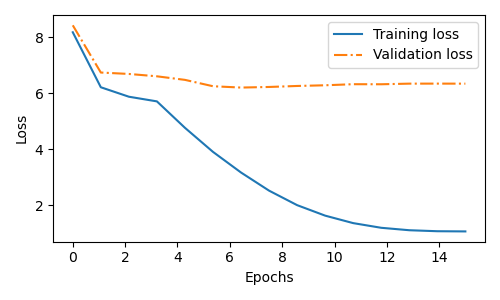

In [23]:
Image('images/train-val-loss.png')

### Text generation using "trained" model and top-k sampling

In [24]:
def generate_topk(model, start_context, context_size, max_new_tokens, 
                    top_k=None, temperature=0.0):
    idx_batch = text_to_idxs(start_context, tokenizer).to(device)
    for _ in range(max_new_tokens):
        cropped_idx_batch = idx_batch[:, -context_size:]
        with torch.no_grad():
            logits = model(cropped_idx_batch)  
        next_token_logits = logits[:, -1, :]  # (batch, n_tokens, vocab_size) -> (batch, vocab_size)

        if top_k is not None:
            top_k_logits, _ = torch.topk(next_token_logits, top_k, dim=-1)
            min_val = top_k_logits[:, -1]
            next_token_logits = torch.where(next_token_logits < min_val, 
                                            torch.ones_like(next_token_logits) * -float('inf'), 
                                            next_token_logits)
    
        if temperature > 0.0:
            next_token_logits = next_token_logits / temperature
            next_token_probs = torch.softmax(next_token_logits, dim=-1)
            next_token_idx = torch.multinomial(next_token_probs, num_samples=1)


        else:
            next_token_idx = torch.argmax(next_token_logits, dim=-1, keepdim=True)
        
        if next_token_idx.item() == CONFIG['vocab_size'] - 1:
            break
        
        idx_batch = torch.cat((idx_batch, next_token_idx), dim=1)
    
    print(idxs_to_text(idx_batch, tokenizer).replace("\n", " "))

In [25]:
torch.manual_seed(42)

for top_k in [1, 3, 5, 10, 100]:
    for temperature in [0.0, 0.5, 1.0, 1.5, 2.0]:
        print(f'top_k: {top_k}, temperature: {temperature}')
        generate_topk(model=model,
                start_context="Every effort moves you",
                context_size=CONFIG["context_length"],
                max_new_tokens=30,
                top_k=top_k,
                temperature=temperature)

top_k: 1, temperature: 0.0
Every effort moves you?"  "Oh, one of his pictures--so the me in a flash that he never thought of the fact, I had been, and
top_k: 1, temperature: 0.5
Every effort moves you?"  "I didn't--I felt him, the his history in the house."         "I
top_k: 1, temperature: 1.0
Every effort moves you?"  "Oh, and he was his pictures--as the last word. "Oh, and went on aing and in the donkey
top_k: 1, temperature: 1.5
Every effort moves you, I had been that, one of the with a deprecating of a flash that he never to me to have women had made him, I
top_k: 1, temperature: 2.0
Every effort moves you?"    "I glanced after--and--as the last he was when she began to me to me to the cigars you know.
top_k: 3, temperature: 0.0
Every effort moves you know," was one of the picture. Gisburn--as the last Gisburn's "Yes--and I felt to have to the.
top_k: 3, temperature: 0.5
Every effort moves you?"  "I didn't. Gisburn--as you in a flash that he never thought of the fact, the cigars y